## Third RL-model: Deep Q-learning

In [1]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers.legacy  import Adam
import tensorflow as tf
import numpy as np
import tqdm

import reinforcement

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Define our Agent**

In [3]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.memory_counter = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.memory_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.memory_counter += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.memory_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal


def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
        Dense(fc1_dims, input_shape=(input_dims,)),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        Dense(n_actions)])

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return model


class DeepQAgent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=100, fname='dqn_model.keras'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 8, 8)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def get_action(self, state, env):
        state = np.asarray(state)
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            return env.action_space.sample()
        else:
            actions = self.q_eval.predict(state, verbose=0)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.memory_counter > self.batch_size:
            state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state, verbose=0)

            q_next = self.q_eval.predict(new_state, verbose=0)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.decay_epsilon()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min,
                           self.epsilon - self.epsilon_dec)

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

**Main Loop for learning**

In [4]:
def run_deepq_learning(env, deepq_agent, n_episodes, **kwargs):
    """method to run training"""
    scores = []
    eps_history = []

    for i in tqdm.tqdm(range(n_episodes)):
        done = False
        score = 0
        observation = env.reset()[0]
        while not done:
            action = deepq_agent.get_action(observation, env)
            observation_, reward, done, info, ff = env.step(action)
            score += reward
            deepq_agent.remember(observation, action,
                                 reward, observation_, int(done))
            observation = observation_
            deepq_agent.learn()

        eps_history.append(deepq_agent.epsilon)
        scores.append(score)

        # avg_score = np.mean(scores[max(0, i-100):(i+1)])
        # print('episode: ', i,'score: %.2f' % score,
        #        ' average score %.2f' % avg_score)

    deepq_agent.save_model()

    return scores, eps_history

**Run Training**

We use a constant epsilon of 0. Using the exploration resulted in always charging 0 kWh.

In [5]:
# hyperparameter
n_episodes = 750
learning_rate = 0.001
start_epsilon = 0
# reduce the exploration over time
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0

env = reinforcement.SmartChargingEnv()

deepq_agent = DeepQAgent(alpha=learning_rate, gamma=0.99, epsilon=start_epsilon, epsilon_dec=epsilon_decay,
                          epsilon_end=final_epsilon, input_dims=2, n_actions=4, mem_size=1000, batch_size=16)

# deepq_agent.load_model()
scores, eps_history = run_deepq_learning(env, deepq_agent, n_episodes)


100%|████████████████████████████████████████████████████████████████████████████████████| 750/750 [16:35<00:00,  1.33s/it]


**Results**

Actions:  [2, 2, 2, 2, 2, 2, 3, 3]
Reward:  -1134.4464871843356
Final Battery Level:  36


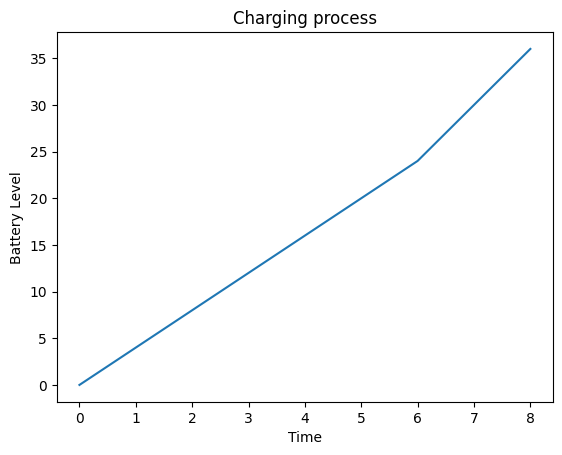

In [6]:
actions, battery_levels, score = reinforcement.run_model(env, deepq_agent)
print("Actions: ", actions)
print("Reward: ", score)
print("Final Battery Level: ", int(battery_levels[-1]))
reinforcement.plot_model_run(battery_levels)

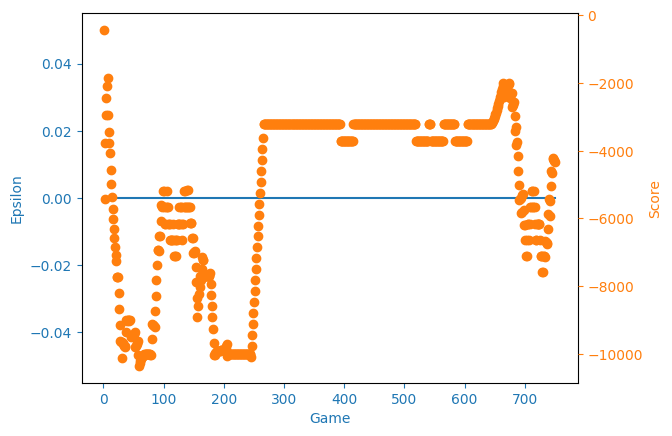

In [7]:
x = [i+1 for i in range(n_episodes)]
reinforcement.plot_learning_rewards_epsilon(
    x, scores, eps_history, "deepqlearning.png")

The results suggest, that the model needs more refinement, e.g adjusting Hyperparameter, more episodes of training or using double DQN.

In [8]:
env.close()